In [1]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [3]:
labels_train_val = pd.read_csv('/kaggle/input/data/train_val_list.txt')
labels_train_val.columns = ['Image_Index']
labels_test = pd.read_csv('/kaggle/input/data/test_list.txt')
labels_test.columns = ['Image_Index']
disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
# NIH Dataset Labels CSV File 
labels_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
labels_df.columns = ['Image_Index', 'Finding_Labels', 'Follow_Up_#', 'Patient_ID',
                  'Patient_Age', 'Patient_Gender', 'View_Position',
                  'Original_Image_Width', 'Original_Image_Height',
                  'Original_Image_Pixel_Spacing_X',
                  'Original_Image_Pixel_Spacing_Y', 'dfd']
# One hot encoding
for diseases in tqdm(disease_labels): 
    labels_df[diseases] = labels_df['Finding_Labels'].map(lambda result: 1 if diseases in result else 0)

# labels_df.to_csv('/kaggle/working/newData.csv')
labels_df=labels_df[labels_df.Finding_Labels != 'No Finding']
# #labels_df.head(3)

100%|██████████| 14/14 [00:01<00:00, 13.83it/s]


In [4]:

labels_df['Finding_Labels'] = labels_df['Finding_Labels'].apply(lambda s: [l for l in str(s).split('|')])

num_glob = glob('/kaggle/input/data/*/images/*.png')
img_path = {os.path.basename(x): x for x in num_glob}

labels_df['Paths'] = labels_df['Image_Index'].map(img_path.get)
labels_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
4,00000003_000.png,[Hernia],0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_000.png
5,00000003_001.png,[Hernia],1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,/kaggle/input/data/images_001/images/00000003_001.png


In [5]:
unique_patients = np.unique(labels_df['Patient_ID'])
len(unique_patients)

14402

In [6]:
from sklearn.model_selection import train_test_split

# train-70
# val-10
# test-20
train_val_df_patients, test_df_patients = train_test_split(unique_patients, 
                                   test_size = 0.2,
                                   random_state = SEED,
                                    shuffle= True
                                   )
len(train_val_df_patients)

11521

In [7]:
train_val_df = labels_df[labels_df['Patient_ID'].isin(train_val_df_patients)]

In [8]:
train_val_df.head()

,Image_Index,Finding_Labels,Follow_Up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,Original_Image_Pixel_Spacing_X,...,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Paths
0,00000001_000.png,[Cardiomegaly],0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",2,1,58,M,PA,2500,2048,0.168,...,0,0,1,0,0,1,0,0,0,/kaggle/input/data/images_001/images/00000001_002.png
12,00000004_000.png,"[Mass, Nodule]",0,4,82,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,1,1,0,/kaggle/input/data/images_001/images/00000004_000.png
19,00000005_006.png,[Infiltration],6,5,70,F,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000005_006.png


In [9]:
labels_df.shape
print('train_val size', train_val_df.shape[0])
print('test size', labels_df.shape[0] - train_val_df.shape[0])

train_val size 41721
test size 10038


In [10]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Paths']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [11]:
from fastai.vision.all import *

arch = 'coatnet_2_rw_224.sw_in12k_ft_in1k'

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]

learn = vision_learner(dls, arch, metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


intial learning rate= 0.0063095735386013985


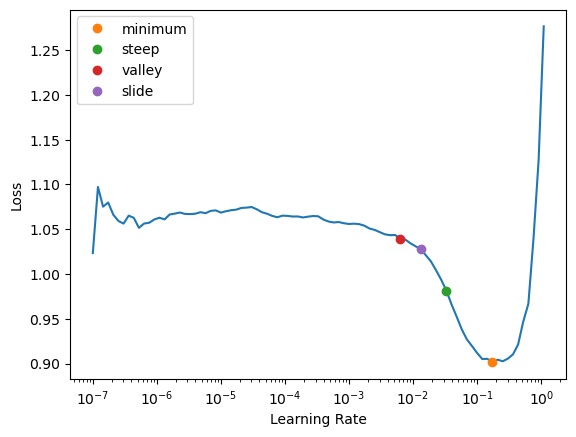

In [12]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.312704,0.295020,0.888139,0.058710,0.649492,24:23
1,0.297402,0.281531,0.890686,0.073104,0.689148,23:33
2,0.280046,0.266455,0.894001,0.091242,0.749931,23:32


Better model found at epoch 0 with valid_loss value: 0.29501962661743164.


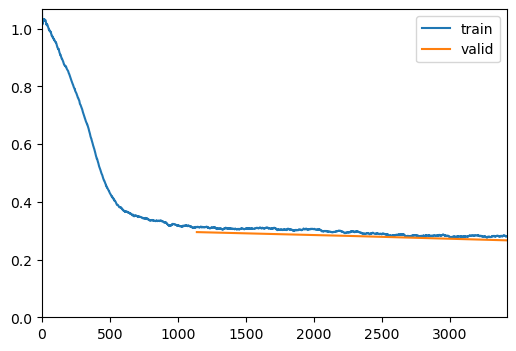

Better model found at epoch 1 with valid_loss value: 0.28153106570243835.
Better model found at epoch 2 with valid_loss value: 0.2664549946784973.


epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time
0,0.259183,0.251514,0.899959,0.187041,0.790675,25:35
1,0.250113,0.245230,0.902328,0.231388,0.809192,25:29
2,0.246468,0.244255,0.903054,0.243405,0.812835,25:40
3,0.239391,0.242772,0.903616,0.239052,0.819169,25:52
4,0.237805,0.242124,0.903822,0.286816,0.824766,25:36
5,0.229370,0.239752,0.905013,0.335372,0.823357,25:33
6,0.224274,0.239713,0.904711,0.341011,0.825160,25:11
7,0.214072,0.243141,0.905081,0.339991,0.819874,25:09
8,0.200569,0.251769,0.903452,0.351369,0.815411,24:58
9,0.192806,0.255297,0.903123,0.344899,0.810034,24:51


Better model found at epoch 0 with valid_loss value: 0.25151416659355164.


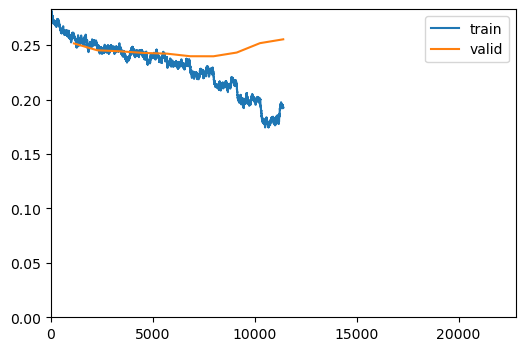

Better model found at epoch 1 with valid_loss value: 0.24522975087165833.
Better model found at epoch 3 with valid_loss value: 0.24277184903621674.
Better model found at epoch 5 with valid_loss value: 0.23975151777267456.
No improvement since epoch 5: early stopping


In [13]:
learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=lrs.valley)

In [14]:
learn.save('coatnet-70-10-20-split')

Path('models/coatnet-70-10-20-split.pth')